10


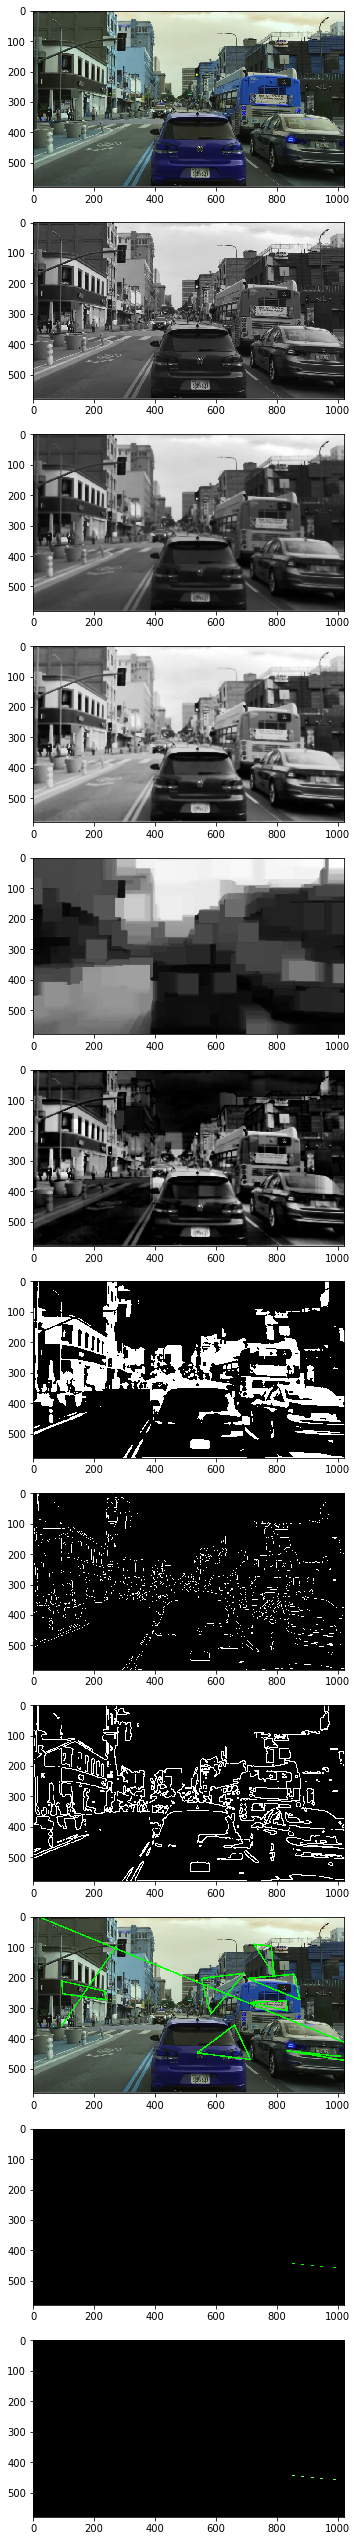

In [25]:
import cv2
# Importing the OpenCV Library
import numpy as np
# Importing NumPy,which is the fundamental package for scientific computing with Python

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

%matplotlib inline

IMG = os.path.join("images","cars","new_scene.jpg")

# Reading Image
img = cv2.imread(IMG)

fig = plt.figure(figsize=(50,50))

fig.add_subplot(13,1,1).imshow(img)

#ax1.imshow(img)

# RGB to Gray scale conversion
img_gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
fig.add_subplot(13,1,2).imshow(img_gray)

# Noise removal with iterative bilateral filter(removes noise while preserving edges)
noise_removal = cv2.bilateralFilter(img_gray,9,75,75)
fig.add_subplot(13,1,3).imshow(noise_removal)


# Histogram equalisation for better results
equal_histogram = cv2.equalizeHist(noise_removal)
fig.add_subplot(13,1,4).imshow(equal_histogram)


# Morphological opening with a rectangular structure element
kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(5,5))
morph_image = cv2.morphologyEx(equal_histogram,cv2.MORPH_OPEN,kernel,iterations=15)
fig.add_subplot(13,1,5).imshow(morph_image)


# Image subtraction(Subtracting the Morphed image from the histogram equalised Image)
sub_morp_image = cv2.subtract(equal_histogram,morph_image)
fig.add_subplot(13,1,6).imshow(sub_morp_image)


# Thresholding the image
ret,thresh_image = cv2.threshold(sub_morp_image,0,255,cv2.THRESH_OTSU)
fig.add_subplot(13,1,7).imshow(thresh_image)


# Applying Canny Edge detection
canny_image = cv2.Canny(thresh_image,250,255)
fig.add_subplot(13,1,8).imshow(canny_image)


# dilation to strengthen the edges
kernel = np.ones((3,3), np.uint8)
# Creating the kernel for dilation
dilated_image = cv2.dilate(canny_image,kernel,iterations=1)
fig.add_subplot(13,1,9).imshow(dilated_image)


# Finding Contours in the image based on edges
new,contours, hierarchy = cv2.findContours(dilated_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contours= sorted(contours, key = cv2.contourArea, reverse = True)[:10]
# Sort the contours based on area ,so that the number plate will be in top 10 contours

print(len(contours))

final = img
screenCnt = None
# loop over our contours
for c in contours:
    # approximate the contour
    peri = cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, 0.06 * peri, True)  # Approximating with 6% error
    # if our approximated contour has four points, then
    # we can assume that we have found our screen
    #if len(approx) == 4:  # Select the contour with 4 corners
    screenCnt = approx
    final = cv2.drawContours(final, [approx], -1, (0, 255, 0), 3)
        #break
        
#final = cv2.drawContours(img, [screenCnt], -1, (0, 255, 0), 3)
fig.add_subplot(13,1,10).imshow(final)


# Masking the part other than the number plate
mask = np.zeros(img_gray.shape,np.uint8)
new_image = cv2.drawContours(mask,[screenCnt],0,255,-1,)
new_image = cv2.bitwise_and(img,img,mask=mask)
fig.add_subplot(13,1,11).imshow(new_image)


# Histogram equal for enhancing the number plate for further processing
y,cr,cb = cv2.split(cv2.cvtColor(new_image,cv2.COLOR_RGB2YCrCb))
# Converting the image to YCrCb model and splitting the 3 channels
y = cv2.equalizeHist(y)
# Applying histogram equalisation
final_image = cv2.cvtColor(cv2.merge([y,cr,cb]),cv2.COLOR_YCrCb2RGB)

fig.add_subplot(13,1,12).imshow(final_image)

plt.show()

16 40
16 40
18 37
15 39
16 40
15 39
15 37
7


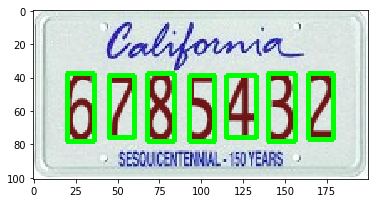

In [10]:
# Code to automatically segment numbers from numberplates by finding contours

import cv2
import os
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.image as mpimg

%matplotlib inline 

IMG = os.path.join("images","cars","plate.jpg")

# Reading Image
img = cv2.imread(IMG)

gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
noise_removal = cv2.bilateralFilter(gray_img,9,75,75)
ret,thresh_image = cv2.threshold(noise_removal,70,255,cv2.THRESH_BINARY_INV)

new,contours, hierarchy = cv2.findContours(thresh_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contours= sorted(contours, key = cv2.contourArea, reverse = True)

for cnt in contours:
    x,y,w,h = cv2.boundingRect(cnt)
    print(w,h)
    cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),2)
  
print(len(contours))

plt.imshow(img)
plt.show()

In [11]:
# Script to randomly generate number plates

from random import randint
 
def gen_plate_number(noc=7):    
    
    CANDIDATES = "0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ" # possible combinations
    NO_OF_CHARS = noc                                   # in the licence plate
    
    plate = ""
    for ch in range(NO_OF_CHARS):
        num = randint(0,35)
        plate += CANDIDATES[num]
        
    return plate

print(gen_plate_number())

W2HFVSA


In [26]:
# Generating the dataset for automatic numberplate recognition

import cv2
import pickle
import requests
from bs4 import BeautifulSoup
from PIL import Image
import numpy as np
import tensorflow as tf

from matplotlib import pyplot as plt
import matplotlib.image as mpimg

%matplotlib inline 

CHARACTERS = "0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ"
N_CLASSES = 36 # ALPHA NUMERIC

def read_dataset(fname="number_plates_new.pickle",N=None):
    f = open(fname,'rb')
    X_data,Y_label = pickle.load(f)
    if not N is None:
        return X_data[:N],Y_label[:N]
    else:
        return X_data, Y_label

def gen_dataset(runs,fname="number_plates_new.pickle"):
    
    X_data, Y_data = [], []
    
    if os.path.exists(fname):
        with open(fname,'rb') as rfp: 
            X_data, Y_data = ( list(data) for data in pickle.load(rfp) )
        rfp.close()
        
    print(len(X_data), len(Y_data))
    
    for idx in range(runs):
        
        print(idx)
        
        # generating a new number
        num = gen_plate_number()
        img, num = generate_plate(num)
        
        x_list,y_list = get_data(img,num)
        
        X_data.extend(x_list)
        Y_data.extend(y_list)
    
    f = open(fname, 'wb')   
    pickle.dump((np.array(X_data), np.array(Y_data)), f)
    f.close()                               

def get_dataset(runs):
    X_data, Y_data = [], []
    
    for idx in range(runs):
        
        # generating a new number
        num = gen_plate_number()
        img, num = generate_plate(num)
        
        x_list,y_list = get_data(img,num)
        
        X_data.extend(x_list)
        Y_data.extend(y_list)
    
    return np.array(X_data), np.array(Y_data)
        
            
        
def one_hot_encoded(label_lst,classes=N_CLASSES):
    return list(np.eye(classes)[label_lst])

def one_hot_decode(lst):
    return np.argmax(lst)

def get_char(num):
    OFFSET = 10
    if num < 10:
        return chr(ord('0') + num) # converting the number to char 
    else:
        return chr(ord('A') + num - OFFSET)

def get_code(ch):
    OFFSET = 10
    if ch.isdigit():
        return ord(ch) - ord('0')
    else:
        return OFFSET + (ord(ch) - ord('A'))
    
def contour_center(cnt):
    
    # finding the moments of the contour
    M = cv2.moments(cnt)
    
    if M["m00"] != 0:
        # center x
        cX = int(M["m10"] / M["m00"])
    else:
        cX = 0
    
    return cX

def get_data(img,num):
    
    x_list, y_list = [], []
    
    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    noise_removal = cv2.bilateralFilter(img,9,75,75)
    
    ret,thresh_image = cv2.threshold(noise_removal,70,255,cv2.THRESH_BINARY_INV)

    new,contours, hierarchy = cv2.findContours(thresh_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # contours sorted by their centers
    contours= sorted(contours, key = contour_center)[:7]
    
    for idx,cnt in enumerate(contours):
        
        x,y,w,h = cv2.boundingRect(cnt)
        
        part = img[y : y + h, x : x + w]
        
        part = cv2.resize(part,(40,18))
        
        _,part = cv2.threshold(part,128,255,cv2.THRESH_BINARY_INV)
        
        part = cv2.normalize(part, 0, 1, cv2.NORM_MINMAX, dtype=cv2.CV_32F)
        
        x_list.append(list(part)) # padded image
        
        y_list.append(one_hot_encoded(get_code(num[idx])))
    
    return x_list, y_list

def display_plate_numbers(img,num):
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    noise_removal = cv2.bilateralFilter(gray_img,9,75,75)
    ret,thresh_image = cv2.threshold(noise_removal,70,255,cv2.THRESH_BINARY_INV)

    new,contours, hierarchy = cv2.findContours(thresh_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # contours sorted by their centers
    contours= sorted(contours, key = contour_center)[:7]
    
    fig = plt.figure()
    
    for idx,cnt in enumerate(contours):
        x,y,w,h = cv2.boundingRect(cnt)
        part = img[y : y + h, x : x + w]
        part = cv2.cvtColor(part,cv2.COLOR_BGR2GRAY)
        _,part = cv2.threshold(part,128,255,cv2.THRESH_BINARY_INV)
        print(h,w)
        plt.gray()
        fig.add_subplot(4,2,idx+1).imshow(part)

    print(len(contours))

    plt.show()


def display_plate(img,num):
    print("Plate Label : ", num )
    plt.imshow(img)
    plt.show()

def display_plate_detected(img):
    
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    noise_removal = cv2.bilateralFilter(gray_img,9,75,75)
    ret,thresh_image = cv2.threshold(noise_removal,70,255,cv2.THRESH_BINARY)

    new,contours, hierarchy = cv2.findContours(thresh_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours= sorted(contours, key = cv2.contourArea, reverse = True)

    for cnt in contours:
        x,y,w,h = cv2.boundingRect(cnt)
        print(h,w)
        cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),2)

    print(len(contours))
    plt.gray()
    plt.imshow(img)
    plt.show()
        

def generate_plate(num):
    html = requests.get("http://acme.com/licensemaker/licensemaker.cgi", 
            params={
                "state" : "California",
                "text"  : num, 
                "plate" : "1998",
                "r"     : "1014181821"
            }).text
    
    soup = BeautifulSoup(html,"html5lib")
    
    URL_DOM = "http://acme.com/licensemaker/"
    URL_IMG = soup('img')[2]['src']
    URL = URL_DOM + URL_IMG
    
    # Fetching the image from the web 
    response = requests.get(URL)
    if response.status_code == 200:
        img_array = np.asarray(bytearray(response.content), dtype=np.uint8)
        return np.array(cv2.imdecode(img_array, cv2.IMREAD_COLOR)),num
    
    # error generting the numberplate
    return None,num

Plate Label :  51L4PFX


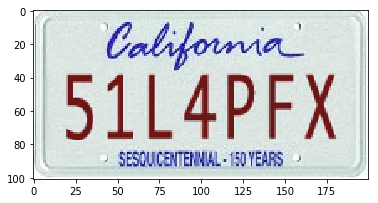

39 15
38 15
37 13
37 18
37 15
37 13
36 16
7


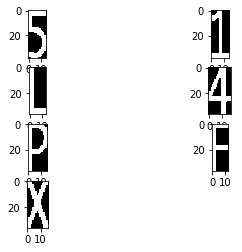

In [27]:
img,num = generate_plate(gen_plate_number())
display_plate(img,num)
display_plate_numbers(img,num)

In [463]:
# Generating Dataset

import os

fname = "number_plates_new.pickle"

gen_dataset(500, fname)
    
print("Done")

38514 38514
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
27

In [15]:
# Reading Dataset
fname = "number_plates_new.pickle"

X_data,Y_label = read_dataset(fname)

# Getting the shapes
print(X_data.shape, Y_label.shape)

(42014, 18, 40) (42014, 36)


P


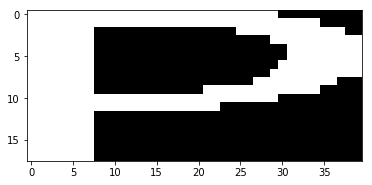

4


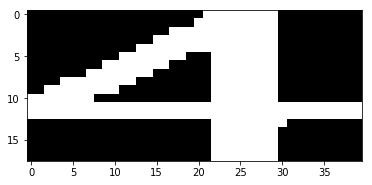

R


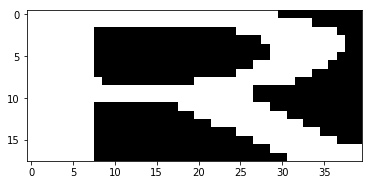

Y


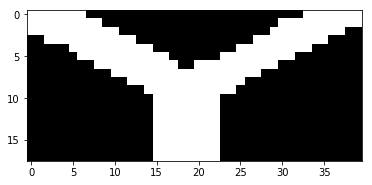

Q


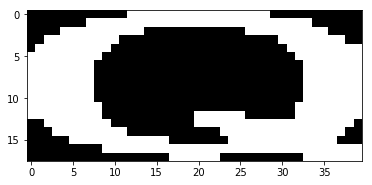

In [16]:
# Render Dataset - Testing

X_data,Y_label = read_dataset(fname,5)

for image, label in zip(X_data,Y_label):
    print(get_char(one_hot_decode(label)))
    plt.imshow(image)
    plt.show()

In [17]:
# Create dataset as MNIST example way

# Reading Dataset
X_data,Y_label = read_dataset()

def read_data_sets(num):
    
    cars = {}
    i = 0
    
    for image, label in zip(X_data, Y_label):
        if i < num:
            if not 'train' in cars:
                cars['train'] = {'images': [], 'labels': []}
            cars['train']['images'].append(image.flatten())
            cars['train']['labels'].append(label)
        else:
            if not 'test' in cars:
                cars['test'] = {'images': [], 'labels': []}
            cars['test']['images'].append(image.flatten())
            cars['test']['labels'].append(label)
        
        i+=1
        
    cars['train']['images'] = np.array(cars['train']['images'])
    cars['train']['labels'] = np.array(cars['train']['labels'])
    cars['test']['images']  = np.array(cars['test']['images'])
    cars['test']['labels']  = np.array(cars['test']['labels'])
        
    return cars


cars = read_data_sets(10)

print(cars['train']['images'].shape)
print(cars['train']['labels'].shape)
print(cars['test']['images'].shape)
print(cars['test']['labels'].shape)

(10, 720)
(10, 36)
(42004, 720)
(42004, 36)


In [19]:
# Training the characters for number plate recognition based on logistic regression

import sys
import tensorflow as tf

cars = read_data_sets(34000)


print(cars['train']['images'].shape)
print(cars['train']['labels'].shape)
print(cars['test']['images'].shape)
print(cars['test']['labels'].shape)

# Create the model
x = tf.placeholder(tf.float32, [None, 720])
W = tf.Variable(tf.zeros([720, 36]))
b = tf.Variable(tf.zeros([36]))
y = tf.matmul(x, W) + b

# Define loss and optimizer
y_ = tf.placeholder(tf.float32, [None, 36])

cross_entropy = tf.reduce_mean(
          tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y))
train_step = tf.train.GradientDescentOptimizer(0.5).minimize(cross_entropy)

sess = tf.InteractiveSession()
tf.global_variables_initializer().run()

saver = tf.train.Saver()
    
# Train
batch_xs, batch_ys = cars['train']['images'], cars['train']['labels']

sess.run(train_step, feed_dict={x: batch_xs, y_: batch_ys})

# Test trained model
correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

print(sess.run(accuracy, feed_dict={x: cars['test']['images'],
                                          y_: cars['test']['labels']}))


save_path = saver.save(sess, "plate_model.ckpt")
print("Model saved in file: %s" % save_path)

(34000, 720)
(34000, 36)
(8014, 720)
(8014, 36)
0.944597
Model saved in file: plate_model.ckpt


INFO:tensorflow:Restoring parameters from plate_model.ckpt
P


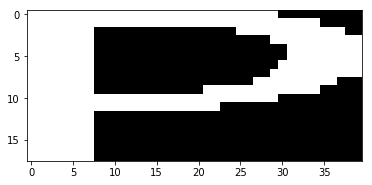

4


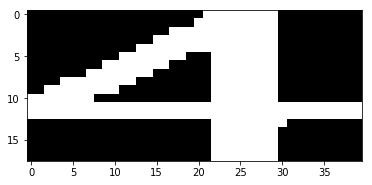

R


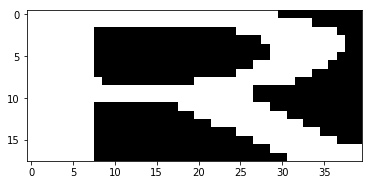

Y


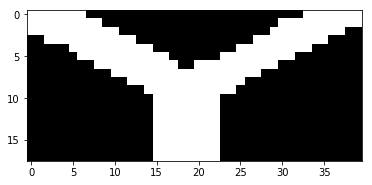

Q


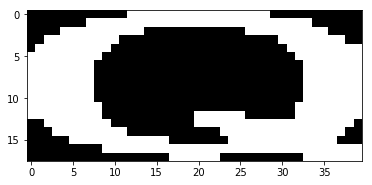

In [20]:
# Predictor
import tensorflow as tf

sess = tf.InteractiveSession()

init_op = tf.global_variables_initializer()

saver = tf.train.Saver()

sess.run(init_op)

saver.restore(sess, "plate_model.ckpt")


def predictint(imvalue):
    """
    This function returns the predicted integer.
    The input is the pixel values from the imageprepare() function.
    """            
    prediction=tf.argmax(y,1)
    return prediction.eval(feed_dict={x: [imvalue]}, session=sess)

# Test images generation

X_data,Y_label = read_dataset(fname,5)

for image, label in zip(X_data,Y_label):
    imvalue = np.array(image).flatten()
    
    label = predictint(imvalue)
    
    print(get_char(label[0]))
    plt.imshow(image)
    plt.show()

In [679]:
# Training the characters for MNIST

import sys
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

# Create the model
x = tf.placeholder(tf.float32, [None, 784])
W = tf.Variable(tf.zeros([784, 10]))
b = tf.Variable(tf.zeros([10]))
y = tf.matmul(x, W) + b

# Define loss and optimizer
y_ = tf.placeholder(tf.float32, [None, 10])

cross_entropy = tf.reduce_mean(
          tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y))
train_step = tf.train.GradientDescentOptimizer(0.5).minimize(cross_entropy)

sess = tf.InteractiveSession()
tf.global_variables_initializer().run()
    
# Train
for _ in range(1000):
    batch_xs, batch_ys = mnist.train.next_batch(100)
    sess.run(train_step, feed_dict={x: batch_xs, y_: batch_ys})

# Test trained model
correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

print(mnist.test.images.shape, mnist.test.labels.shape)

print(sess.run(accuracy, feed_dict={x: mnist.test.images,
                                          y_: mnist.test.labels}))


save_path = saver.save(sess, "mnist_plate_model.ckpt")
print("Model saved in file: %s" % save_path)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
(10000, 784) (10000, 10)
0.9195
Model saved in file: mnist_plate_model.ckpt


INFO:tensorflow:Restoring parameters from plate_model.ckpt
63MW637
No of number plates detected : 1


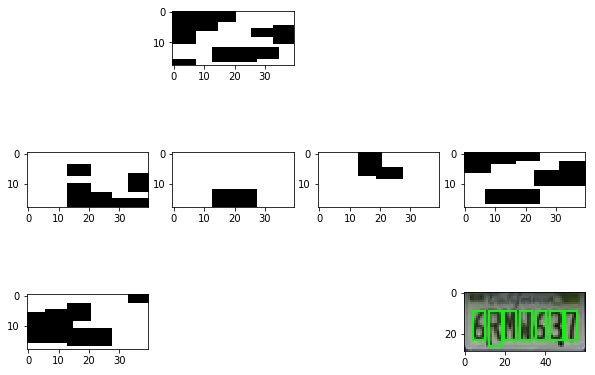

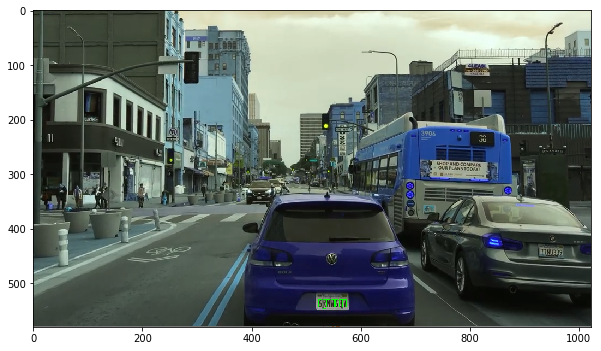

In [33]:
# Number Plate Localization

import cv2
import glob
import math
import numpy as np

from matplotlib import pyplot as plt
import matplotlib.image as mpimg

%matplotlib inline 

import tensorflow as tf

sess = tf.Session()    

init_op = tf.global_variables_initializer()

saver = tf.train.Saver()

sess.run(init_op)

# Using my custom Model
saver.restore(sess, "plate_model.ckpt")

# Using MNIST Model
#saver.restore(sess, "model.ckpt")

fig = plt.figure(figsize=(10,10))

def predictint2(imvalue):
    """
    This function returns the predicted integer.
    The input is the pixel values from the imageprepare() function.
    """
    prediction=tf.argmax(y,1)
    return prediction.eval(feed_dict={x: [imvalue]}, session=sess)


def match_area(cnt):
    area = cv2.contourArea(cnt) 
    return area >= 1400 and area <= 2000

def predict_number(img):
    
    detected_number = ''
     
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    equal_histogram = cv2.equalizeHist(img_gray)
    
    ret,thresh_image = cv2.threshold(equal_histogram,50,255,cv2.THRESH_BINARY_INV)
  
    new, contours, hierarchy = cv2.findContours(thresh_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    contours= sorted(contours, key = contour_center)
      
    count = 0
          
    for idx, cnt in enumerate(contours):
        
        p,q,w,h = cv2.boundingRect(cnt)
        
        aspect_ratio = h / w
            
        if aspect_ratio >= 2.1 and aspect_ratio <= 2.85:
            
            count += 1
        
            part = img_gray[q : q + h, p : p + w]
            
            cv2.rectangle(img,(p,q),(p+w,q+h),(0,255,0),1)
            
            # Resize when using custom model
            part = cv2.resize(part,(40,18), interpolation=cv2.INTER_NEAREST)
            
            # Resize to MNIST model
            #part = cv2.resize(part,(28,28), interpolation=cv2.INTER_NEAREST)
            
            _,part = cv2.threshold(part,128,255,cv2.THRESH_BINARY_INV)
            
            
            # lets do erosion
            kernel = np.ones((3,3),np.uint8)
            part = cv2.erode(part,kernel,iterations = 1)

            part = cv2.normalize(part, 0, 1, cv2.NORM_MINMAX, dtype=cv2.CV_32F)

            label = predictint2(part.flatten())
            label = get_char(label[0])
            
            detected_number += label

            fig.add_subplot(4,4,idx+1).imshow(part)
    
    return detected_number
    

"""
Detector Code

"""

IMG = os.path.join("images","cars","new_scene.jpg")

img = cv2.imread(IMG)

# Gray Image
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Histogram equalisation for better results
equal_histogram = cv2.equalizeHist(img_gray)

_, thres_image = cv2.threshold(equal_histogram, 200, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

new, contours, hierarchy = cv2.findContours(thres_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

num_plates = 0

for cnt in contours:
    #area = cv2.contourArea(cnt)         
    #if area >= 1400 and area <= 1500:
    rect = cv2.minAreaRect(cnt)
    width = rect[1][0]
    height = rect[1][1]
    
    area = cv2.contourArea(cnt) 
    if area >= 1400 and area <= 1500:
            
        num_plates += 1
        
        p,q,w,h = cv2.boundingRect(cnt)
        
        part = img[q : q + h, p : p + w]
        
        number = predict_number(part)
        
        print(number)
        
        font = cv2.FONT_HERSHEY_SIMPLEX
        cv2.putText(part, number, (p,q), font, 0.3, (255, 0, 0), 2)
        
        plt.imshow(part)
       

fig = plt.figure("Input Image",figsize=(10,10))

fig.add_subplot(1,1,1).imshow(img)
    
print("No of number plates detected : {0}".format(num_plates))

plt.show()

In [2]:
# Installing ffmpeg for playing video's in notebook

import imageio

imageio.plugins.ffmpeg.download()

Imageio: 'ffmpeg.osx' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg.osx (28.8 MB)
Downloading: 8192/30241064 bytes (0.0663552/30241064 bytes (2.22269184/30241064 bytes (7.5%4857856/30241064 bytes (16.17897088/30241064 bytes (26.111173888/30241064 bytes (36.9%14147584/30241064 bytes (46.8%17571840/30241064 bytes (58.1%20963328/30241064 bytes (69.3%24666112/30241064 bytes (81.6%28844032/30241064 bytes (95.4%30241064/30241064 bytes (100.0%)
  Done
File saved as /Users/rmunshi/Library/Application Support/imageio/ffmpeg/ffmpeg.osx.


In [35]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML


input_video  = "drive.mp4"
output_video = 'drive_out.mp4'

#input_video = VideoFileClip('drive.mp4').subclip(0,10)
#input_clip = input_video.fl_image(process_image)
#%time input_clip.write_videofile(output_video, audio=False)


HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(input_video))